**Imports**

In [1]:
# imports
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
from sklearn.impute          import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
# para ser usado no Boxplot comparativo
results = []
labels = []



---



**Estratégia 1 - Remover Dados Ausentes**

In [3]:
# Dataset disponível como CSV
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
response = requests.get(url)

# Nomes das colunas segundo a documentação UCI
colunas = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]

# Leitura do conteúdo como CSV (valores faltantes são marcados como '?')
df = pd.read_csv(StringIO(response.text), header=None, names=colunas, na_values='?')

# Visualização inicial
df.head()

# Verificar valores ausentes
print("Valores faltantes por coluna:\n", df.isna().sum())

# Remover linhas com valores ausentes
df = df.dropna()

# Converter colunas para tipos corretos
df = df.astype({
    'ca': int, 'thal': int
})

# A variável target tem valores 0 (sem doença) a 4 (com níveis de doença)
# Vamos binarizar: 0 = sem doença, 1 = com doença
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

# Separar atributos e rótulo
X_orig = df.drop(columns=['target'])
Y_orig = df['target']

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X_orig), columns=X_orig.columns)
Y = Y_orig.copy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=42)

X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(X_orig, Y_orig, test_size=0.25, stratify=Y_orig, random_state=42)

modelo_orig = SVC()
modelo_orig.fit(X_orig_train, y_orig_train)

print("🔎 Avaliação com dados ORIGINAIS (Treino):")
print(confusion_matrix(y_orig_train, modelo_orig.predict(X_orig_train)))
print(classification_report(y_orig_train, modelo_orig.predict(X_orig_train)))

print("🔎 Avaliação com dados ORIGINAIS (Teste):")
print(confusion_matrix(y_orig_test, modelo_orig.predict(X_orig_test)))
print(classification_report(y_orig_test, modelo_orig.predict(X_orig_test)))

modelo = SVC(class_weight='balanced', random_state=42)
modelo.fit(X_train, y_train)

print(" Avaliação com dados NORMALIZADOS (Treino):")
print(confusion_matrix(y_train, modelo.predict(X_train)))
print(classification_report(y_train, modelo.predict(X_train)))

print("Avaliação com dados NORMALIZADOS (Teste):")
print(confusion_matrix(y_test, modelo.predict(X_test)))
print(classification_report(y_test, modelo.predict(X_test)))

# Cross-validation sobre todo o conjunto normalizado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    SVC(class_weight='balanced', random_state=42),
    X, Y,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1
)
print(f"🔄 Cross-Validation — Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

# Adicionar para Boxplot comparativo
results.append(scores)
labels.append('dropna')

Valores faltantes por coluna:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64
🔎 Avaliação com dados ORIGINAIS (Treino):
[[104  16]
 [ 59  43]]
              precision    recall  f1-score   support

           0       0.64      0.87      0.73       120
           1       0.73      0.42      0.53       102

    accuracy                           0.66       222
   macro avg       0.68      0.64      0.63       222
weighted avg       0.68      0.66      0.64       222

🔎 Avaliação com dados ORIGINAIS (Teste):
[[33  7]
 [17 18]]
              precision    recall  f1-score   support

           0       0.66      0.82      0.73        40
           1       0.72      0.51      0.60        35

    accuracy                           0.68        75
   macro avg       0.69      0.67      0.67        75
weighted avg       0.69      0.68   



---



**Estratégia 2 - Imputação dos Dados Ausentes pela média**

In [4]:
# Dataset disponível como CSV
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
response = requests.get(url)

# Nomes das colunas segundo a documentação UCI
colunas = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]

# Leitura do conteúdo como CSV (valores faltantes são marcados como '?')
df = pd.read_csv(StringIO(response.text), header=None, names=colunas, na_values='?')

# Visualização inicial
df.head()

# Verificar valores ausentes
print("Valores faltantes por coluna:\n", df.isna().sum())

# Imputa média
imp_mean = SimpleImputer(strategy='mean')
df = df.copy()
df[['ca','thal']] = imp_mean.fit_transform(df[['ca','thal']])

# Converter colunas para tipos corretos
df = df.astype({
    'ca': int, 'thal': int
})

# A variável target tem valores 0 (sem doença) a 4 (com níveis de doença)
# Vamos binarizar: 0 = sem doença, 1 = com doença
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

# Separar atributos e rótulo
X_orig = df.drop(columns=['target'])
Y_orig = df['target']

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X_orig), columns=X_orig.columns)
Y = Y_orig.copy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=42)

X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(X_orig, Y_orig, test_size=0.25, stratify=Y_orig, random_state=42)

modelo_orig = SVC()
modelo_orig.fit(X_orig_train, y_orig_train)

print("🔎 Avaliação com dados ORIGINAIS (Treino):")
print(confusion_matrix(y_orig_train, modelo_orig.predict(X_orig_train)))
print(classification_report(y_orig_train, modelo_orig.predict(X_orig_train)))

print("🔎 Avaliação com dados ORIGINAIS (Teste):")
print(confusion_matrix(y_orig_test, modelo_orig.predict(X_orig_test)))
print(classification_report(y_orig_test, modelo_orig.predict(X_orig_test)))

modelo = SVC(class_weight='balanced', random_state=42)
modelo.fit(X_train, y_train)

print(" Avaliação com dados NORMALIZADOS (Treino):")
print(confusion_matrix(y_train, modelo.predict(X_train)))
print(classification_report(y_train, modelo.predict(X_train)))

print("Avaliação com dados NORMALIZADOS (Teste):")
print(confusion_matrix(y_test, modelo.predict(X_test)))
print(classification_report(y_test, modelo.predict(X_test)))

# Cross-validation sobre todo o conjunto normalizado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    SVC(class_weight='balanced', random_state=42),
    X, Y,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1
)
print(f"🔄 Cross-Validation — Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

# Adicionar para Boxplot comparativo
results.append(scores)
labels.append('mean')

Valores faltantes por coluna:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64
🔎 Avaliação com dados ORIGINAIS (Treino):
[[105  18]
 [ 59  45]]
              precision    recall  f1-score   support

           0       0.64      0.85      0.73       123
           1       0.71      0.43      0.54       104

    accuracy                           0.66       227
   macro avg       0.68      0.64      0.64       227
weighted avg       0.67      0.66      0.64       227

🔎 Avaliação com dados ORIGINAIS (Teste):
[[35  6]
 [18 17]]
              precision    recall  f1-score   support

           0       0.66      0.85      0.74        41
           1       0.74      0.49      0.59        35

    accuracy                           0.68        76
   macro avg       0.70      0.67      0.67        76
weighted avg       0.70      0.68   



---



**Estratégia 2 - Imputação dos Dados Ausentes pela mediana**

In [5]:
# Dataset disponível como CSV
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
response = requests.get(url)

# Nomes das colunas segundo a documentação UCI
colunas = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]

# Leitura do conteúdo como CSV (valores faltantes são marcados como '?')
df = pd.read_csv(StringIO(response.text), header=None, names=colunas, na_values='?')

# Visualização inicial
df.head()

# Verificar valores ausentes
print("Valores faltantes por coluna:\n", df.isna().sum())

# Imputa mediana
imp_med = SimpleImputer(strategy='median')
df = df.copy()
df[['ca','thal']] = imp_med.fit_transform(df[['ca','thal']])

# Converter colunas para tipos corretos
df = df.astype({
    'ca': int, 'thal': int
})

# A variável target tem valores 0 (sem doença) a 4 (com níveis de doença)
# Vamos binarizar: 0 = sem doença, 1 = com doença
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

# Separar atributos e rótulo
X_orig = df.drop(columns=['target'])
Y_orig = df['target']

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X_orig), columns=X_orig.columns)
Y = Y_orig.copy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=42)

X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(X_orig, Y_orig, test_size=0.25, stratify=Y_orig, random_state=42)

modelo_orig = SVC()
modelo_orig.fit(X_orig_train, y_orig_train)

print("🔎 Avaliação com dados ORIGINAIS (Treino):")
print(confusion_matrix(y_orig_train, modelo_orig.predict(X_orig_train)))
print(classification_report(y_orig_train, modelo_orig.predict(X_orig_train)))

print("🔎 Avaliação com dados ORIGINAIS (Teste):")
print(confusion_matrix(y_orig_test, modelo_orig.predict(X_orig_test)))
print(classification_report(y_orig_test, modelo_orig.predict(X_orig_test)))

modelo = SVC(class_weight='balanced', random_state=42)
modelo.fit(X_train, y_train)

print(" Avaliação com dados NORMALIZADOS (Treino):")
print(confusion_matrix(y_train, modelo.predict(X_train)))
print(classification_report(y_train, modelo.predict(X_train)))

print("Avaliação com dados NORMALIZADOS (Teste):")
print(confusion_matrix(y_test, modelo.predict(X_test)))
print(classification_report(y_test, modelo.predict(X_test)))

# Cross-validation sobre todo o conjunto normalizado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    SVC(class_weight='balanced', random_state=42),
    X, Y,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1
)
print(f"🔄 Cross-Validation — Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

# Adicionar para Boxplot comparativo
results.append(scores)
labels.append('median')

Valores faltantes por coluna:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64
🔎 Avaliação com dados ORIGINAIS (Treino):
[[105  18]
 [ 59  45]]
              precision    recall  f1-score   support

           0       0.64      0.85      0.73       123
           1       0.71      0.43      0.54       104

    accuracy                           0.66       227
   macro avg       0.68      0.64      0.64       227
weighted avg       0.67      0.66      0.64       227

🔎 Avaliação com dados ORIGINAIS (Teste):
[[35  6]
 [18 17]]
              precision    recall  f1-score   support

           0       0.66      0.85      0.74        41
           1       0.74      0.49      0.59        35

    accuracy                           0.68        76
   macro avg       0.70      0.67      0.67        76
weighted avg       0.70      0.68   



---



**Estratégia 3 - Imputação dos Dados Ausentes pela moda**



In [6]:
# Dataset disponível como CSV
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
response = requests.get(url)

# Nomes das colunas segundo a documentação UCI
colunas = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]

# Leitura do conteúdo como CSV (valores faltantes são marcados como '?')
df = pd.read_csv(StringIO(response.text), header=None, names=colunas, na_values='?')

# Visualização inicial
df.head()

# Verificar valores ausentes
print("Valores faltantes por coluna:\n", df.isna().sum())

# Imputa moda
imp_freq = SimpleImputer(strategy='most_frequent')
df = df.copy()
df[['ca','thal']] = imp_freq.fit_transform(df[['ca','thal']])

# Converter colunas para tipos corretos
df = df.astype({
    'ca': int, 'thal': int
})

# A variável target tem valores 0 (sem doença) a 4 (com níveis de doença)
# Vamos binarizar: 0 = sem doença, 1 = com doença
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

# Separar atributos e rótulo
X_orig = df.drop(columns=['target'])
Y_orig = df['target']

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X_orig), columns=X_orig.columns)
Y = Y_orig.copy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=42)

X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(X_orig, Y_orig, test_size=0.25, stratify=Y_orig, random_state=42)

modelo_orig = SVC()
modelo_orig.fit(X_orig_train, y_orig_train)

print("🔎 Avaliação com dados ORIGINAIS (Treino):")
print(confusion_matrix(y_orig_train, modelo_orig.predict(X_orig_train)))
print(classification_report(y_orig_train, modelo_orig.predict(X_orig_train)))

print("🔎 Avaliação com dados ORIGINAIS (Teste):")
print(confusion_matrix(y_orig_test, modelo_orig.predict(X_orig_test)))
print(classification_report(y_orig_test, modelo_orig.predict(X_orig_test)))

modelo = SVC(class_weight='balanced', random_state=42)
modelo.fit(X_train, y_train)

print(" Avaliação com dados NORMALIZADOS (Treino):")
print(confusion_matrix(y_train, modelo.predict(X_train)))
print(classification_report(y_train, modelo.predict(X_train)))

print("Avaliação com dados NORMALIZADOS (Teste):")
print(confusion_matrix(y_test, modelo.predict(X_test)))
print(classification_report(y_test, modelo.predict(X_test)))

# Cross-validation sobre todo o conjunto normalizado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    SVC(class_weight='balanced', random_state=42),
    X, Y,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1
)
print(f"🔄 Cross-Validation — Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

# Adicionar para Boxplot comparativo
results.append(scores)
labels.append('most_frequent')

Valores faltantes por coluna:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64
🔎 Avaliação com dados ORIGINAIS (Treino):
[[105  18]
 [ 59  45]]
              precision    recall  f1-score   support

           0       0.64      0.85      0.73       123
           1       0.71      0.43      0.54       104

    accuracy                           0.66       227
   macro avg       0.68      0.64      0.64       227
weighted avg       0.67      0.66      0.64       227

🔎 Avaliação com dados ORIGINAIS (Teste):
[[35  6]
 [18 17]]
              precision    recall  f1-score   support

           0       0.66      0.85      0.74        41
           1       0.74      0.49      0.59        35

    accuracy                           0.68        76
   macro avg       0.70      0.67      0.67        76
weighted avg       0.70      0.68   



---



**Estratégia 4 - Imputação dos Dados Ausentes pela constante igual a zero**

In [7]:
# Dataset disponível como CSV
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
response = requests.get(url)

# Nomes das colunas segundo a documentação UCI
colunas = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]

# Leitura do conteúdo como CSV (valores faltantes são marcados como '?')
df = pd.read_csv(StringIO(response.text), header=None, names=colunas, na_values='?')

# Visualização inicial
df.head()

# Verificar valores ausentes
print("Valores faltantes por coluna:\n", df.isna().sum())

# Imputa constante igual a zero
imp_const = SimpleImputer(strategy='constant', fill_value=0)
df = df.copy()
df[['ca','thal']] = imp_const.fit_transform(df[['ca','thal']])

# Converter colunas para tipos corretos
df = df.astype({
    'ca': int, 'thal': int
})

# A variável target tem valores 0 (sem doença) a 4 (com níveis de doença)
# Vamos binarizar: 0 = sem doença, 1 = com doença
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

# Separar atributos e rótulo
X_orig = df.drop(columns=['target'])
Y_orig = df['target']

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X_orig), columns=X_orig.columns)
Y = Y_orig.copy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=42)

X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(X_orig, Y_orig, test_size=0.25, stratify=Y_orig, random_state=42)

modelo_orig = SVC()
modelo_orig.fit(X_orig_train, y_orig_train)

print("🔎 Avaliação com dados ORIGINAIS (Treino):")
print(confusion_matrix(y_orig_train, modelo_orig.predict(X_orig_train)))
print(classification_report(y_orig_train, modelo_orig.predict(X_orig_train)))

print("🔎 Avaliação com dados ORIGINAIS (Teste):")
print(confusion_matrix(y_orig_test, modelo_orig.predict(X_orig_test)))
print(classification_report(y_orig_test, modelo_orig.predict(X_orig_test)))

modelo = SVC(class_weight='balanced', random_state=42)
modelo.fit(X_train, y_train)

print(" Avaliação com dados NORMALIZADOS (Treino):")
print(confusion_matrix(y_train, modelo.predict(X_train)))
print(classification_report(y_train, modelo.predict(X_train)))

print("Avaliação com dados NORMALIZADOS (Teste):")
print(confusion_matrix(y_test, modelo.predict(X_test)))
print(classification_report(y_test, modelo.predict(X_test)))

# Cross-validation sobre todo o conjunto normalizado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    SVC(class_weight='balanced', random_state=42),
    X, Y,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1
)
print(f"🔄 Cross-Validation — Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

# Adicionar para Boxplot comparativo
results.append(scores)
labels.append('constant')

Valores faltantes por coluna:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64
🔎 Avaliação com dados ORIGINAIS (Treino):
[[105  18]
 [ 59  45]]
              precision    recall  f1-score   support

           0       0.64      0.85      0.73       123
           1       0.71      0.43      0.54       104

    accuracy                           0.66       227
   macro avg       0.68      0.64      0.64       227
weighted avg       0.67      0.66      0.64       227

🔎 Avaliação com dados ORIGINAIS (Teste):
[[35  6]
 [18 17]]
              precision    recall  f1-score   support

           0       0.66      0.85      0.74        41
           1       0.74      0.49      0.59        35

    accuracy                           0.68        76
   macro avg       0.70      0.67      0.67        76
weighted avg       0.70      0.68   



---



**Boxplot Comparativo das Estratégia**

/tmp/ipython-input-8-4077973512.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=labels, showmeans=True)


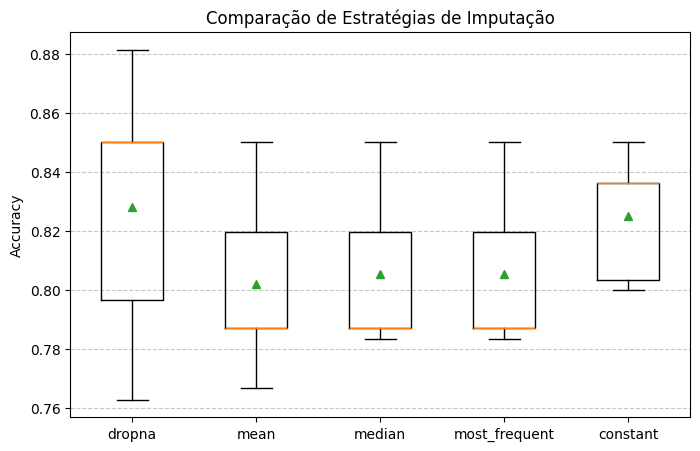

In [8]:
# Boxplot comparativo
plt.figure(figsize=(8,5))
plt.boxplot(results, labels=labels, showmeans=True)
plt.title("Comparação de Estratégias de Imputação")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()